## 「部品基盤のはんだ付け状態」の良品、不良品を判定
##  前処理

In [1]:
import numpy as np
import pandas as pd

import cv2

import matplotlib.pyplot as plt

import keras as ks
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

import os
import glob

%matplotlib inline


Using TensorFlow backend.


## train, test のイメージ読み込み

In [2]:
# path の設定
test_path = "../data/test/"
train_path ='../data/train/'

In [3]:
# test データ読み込み
test_dir = []
for foldername in os.listdir(test_path):
    imgs_path = test_path + foldername
    print(imgs_path)
    imgs = sorted(glob.glob(imgs_path + "/" + "*.jpeg"))
    
    for name in imgs:
        test_dir.append((str(name), str(foldername)))


../data/test/test


In [4]:
# データフレームに格納
test_df = pd.DataFrame(test_dir, columns=['Image', 'Label'], index=None)

In [5]:
test_df.head()

,Image,Label
0,../data/test/test\000.jpeg,test
1,../data/test/test\001.jpeg,test
2,../data/test/test\002.jpeg,test
3,../data/test/test\003.jpeg,test
4,../data/test/test\004.jpeg,test


In [6]:
test_df.shape

(213, 2)

In [7]:
# テストデータのファイル名
y_test_image = test_df.Image

In [8]:
# train データの読み込み
train_dir = []
for foldername in os.listdir(train_path):
    imgs_path = train_path + foldername + "/"
    imgs = sorted(glob.glob(imgs_path + "*.jpeg"))
    
    for name in imgs:
        train_dir.append((str(name), str(foldername)))


In [9]:
# データフレームに格納
train_df = pd.DataFrame(train_dir, columns=['Image', 'Label'], index=None)

In [10]:
train_df.head()

,Image,Label
0,../data/train/bridge\bridge_000.jpeg,bridge
1,../data/train/bridge\bridge_001.jpeg,bridge
2,../data/train/bridge\bridge_002.jpeg,bridge
3,../data/train/bridge\bridge_003.jpeg,bridge
4,../data/train/bridge\bridge_004.jpeg,bridge


In [11]:
train_df.shape, test_df.shape

((400, 2), (213, 2))

In [12]:
train_df.Label.value_counts()

potato        103
regular       100
bridge_crt     68
horn           57
horn_crt       42
bridge         30
Name: Label, dtype: int64

In [13]:
# シャッフル
# test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)


In [14]:
# データのレコード数を確認
print("訓練データ0のレコード数：", len(train_df))
print("テストデータのレコード数：", len(test_df))

訓練データ0のレコード数： 400
テストデータのレコード数： 213


## 訓練データの前処理

In [15]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

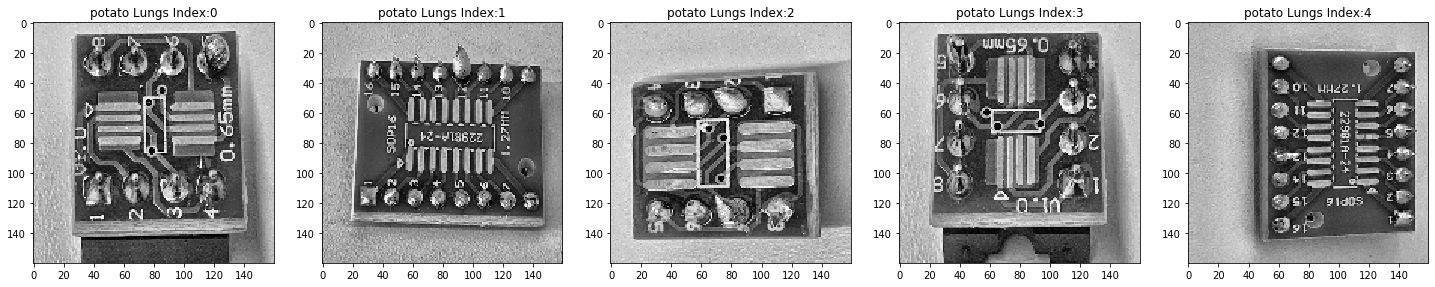

In [16]:
# ５枚だけ表示して確認
# 訓練データの前処理
img_list = []
fundation = []

fig, ax = plt.subplots(1, 5, figsize=(25, 6))

# 各画像ごとに前処理
for i in range(5):
    # 読み込み
#     print(i)
    fundation = cv2.imread(train_df['Image'][i], 0)
    # ヒストグラム平坦化
    fundation = clahe.apply(fundation)
    # リサイズ
    fundation = cv2.resize(fundation, (224, 224))
    # 真ん中あたりを取り出し
    fundation = fundation[25:185, 30:190]
    # サイズを 224, 224 に
    # fundation = cv2.resize(fundation, (224, 224))
    # ３チャネルにする
    fundation = cv2.cvtColor(fundation, cv2.COLOR_GRAY2RGB)
    ax = plt.subplot(1, 5, i+1)
    title = 'potato Lungs Index:' + str(i)
    plt.imshow(fundation, cmap='binary')
    plt.title(title)    
    # to numpy array
    fundation = image.img_to_array(fundation)
#     # 次元 0追加
#     fundation = np.expand_dims(fundation, axis=0)
    # 正規化 しない。後で preprocess_inputs する
#     fundation = fundation.astype('float32') / 255
    img_list.append(fundation)

# Numpy Array
X_train = np.array(img_list)

In [17]:
# 訓練データの前処理
img_list = []
fundation = []

# 各画像ごとに前処理
for i in range(len(train_df)):
    # 読み込み
#     print(i)
    fundation = cv2.imread(train_df['Image'][i], 0)
    # ヒストグラム平坦化
    fundation = clahe.apply(fundation)
    # リサイズ
    fundation = cv2.resize(fundation, (224, 224))
    # 真ん中あたりを取り出し
    fundation = fundation[25:185, 30:190]
    # サイズを 224, 224 に
#     fundation = cv2.resize(fundation, (224, 224))
    # ３チャネルにする
    fundation = cv2.cvtColor(fundation, cv2.COLOR_GRAY2RGB)
    # to numpy array
    fundation = image.img_to_array(fundation)
    # 標準化
#     fundation /= 255
#     # 次元 0追加
#     fundation = np.expand_dims(fundation, axis=0)
    # 正規化 しない。後で preprocess_inputs する
#     fundation = fundation.astype('float32') / 255
    img_list.append(fundation)

# Numpy Array
X_train = np.array(img_list)

In [18]:
X_train.shape

(400, 160, 160, 3)

In [19]:
X_train[0]

array([[[204., 204., 204.],
        [201., 201., 201.],
        [206., 206., 206.],
        ...,
        [199., 199., 199.],
        [201., 201., 201.],
        [205., 205., 205.]],

       [[202., 202., 202.],
        [199., 199., 199.],
        [204., 204., 204.],
        ...,
        [195., 195., 195.],
        [194., 194., 194.],
        [173., 173., 173.]],

       [[203., 203., 203.],
        [212., 212., 212.],
        [204., 204., 204.],
        ...,
        [184., 184., 184.],
        [195., 195., 195.],
        [200., 200., 200.]],

       ...,

       [[155., 155., 155.],
        [189., 189., 189.],
        [165., 165., 165.],
        ...,
        [172., 172., 172.],
        [185., 185., 185.],
        [190., 190., 190.]],

       [[157., 157., 157.],
        [211., 211., 211.],
        [177., 177., 177.],
        ...,
        [170., 170., 170.],
        [197., 197., 197.],
        [196., 196., 196.]],

       [[155., 155., 155.],
        [189., 189., 189.],
        [189., 1

In [20]:
X_train.max(), X_train.min()

(255.0, 0.0)

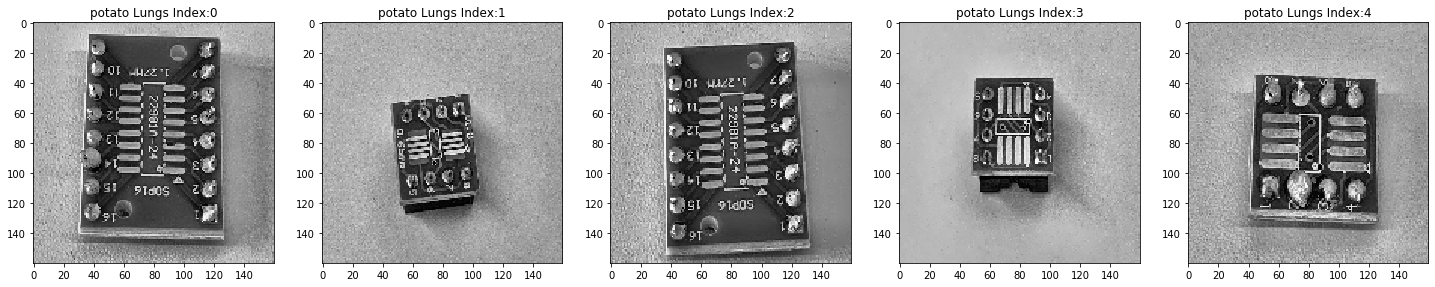

In [21]:
# テストデータの前処理 5枚だけ確認
img_list2 = []
fundation2 = []

fig, ax = plt.subplots(1, 5, figsize=(25, 6))

# 各画像ごとに前処理
for i in range(5):
    # 読み込み
#     print(i)
    fundation2 = cv2.imread(test_df['Image'][i], 0)
    # ヒストグラム平坦化
    fundation2 = clahe.apply(fundation2)
    # リサイズ
    fundation2 = cv2.resize(fundation2, (224, 224))
    # 真ん中あたりを取り出し
    fundation2 = fundation2[25:185, 30:190]
    # サイズを 224, 224 に
#     fundation2 = cv2.resize(fundation2, (224, 224))
    # ３チャネルにする
    fundation2 = cv2.cvtColor(fundation2, cv2.COLOR_GRAY2RGB)
    ax = plt.subplot(1, 5, i+1)
    title = 'potato Lungs Index:' + str(i)
    plt.imshow(fundation2, cmap='binary')
    plt.title(title)    
    # to numpy array
    fundation2 = image.img_to_array(fundation2)
    img_list2.append(fundation2)

# Numpy Array
X_test = np.array(img_list2)

In [22]:
# テストデータの前処理
img_list2 = []
fundation2 = []

# 各画像ごとに前処理
for i in range(len(test_df)):
    # 読み込み
#     print(i)
    fundation2 = cv2.imread(test_df['Image'][i], 0)
    # ヒストグラム平坦化
    fundation2 = clahe.apply(fundation2)
    # リサイズ
    fundation2 = cv2.resize(fundation2, (224, 224))
    # 真ん中あたりを取り出し
    fundation2 = fundation2[25:185, 30:190]
    # サイズを 224, 224 に
#     fundation2 = cv2.resize(fundation2, (224, 224))
    # ３チャネルにする
    fundation2 = cv2.cvtColor(fundation2, cv2.COLOR_GRAY2RGB)
    # to numpy array
    fundation2 = image.img_to_array(fundation2)
    # 標準化
#     fundation2 /= 255
    img_list2.append(fundation2)

# Numpy Array
X_test = np.array(img_list2)

In [23]:
X_train.shape, X_test.shape

((400, 160, 160, 3), (213, 160, 160, 3))

In [24]:
X_test.max(), X_test.min()

(255.0, 0.0)

In [25]:
train_df.Label.value_counts()

potato        103
regular       100
bridge_crt     68
horn           57
horn_crt       42
bridge         30
Name: Label, dtype: int64

## ターゲット

In [26]:
# ターゲット
# 正常を 0, 肺炎を 1
y_train = np.where(train_df['Label'] == "regular", 0, 1)
y_test = np.where(test_df['Label'] == "regular", 0, 1)

In [27]:
y_train.sum(), y_test.sum()

(300, 213)

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((400, 160, 160, 3), (400,), (213, 160, 160, 3), (213,))

In [29]:
# テストデータのファイル名
y_test_image = test_df.Image

In [30]:
y_test_image[:5]

0    ../data/test/test\000.jpeg
1    ../data/test/test\001.jpeg
2    ../data/test/test\002.jpeg
3    ../data/test/test\003.jpeg
4    ../data/test/test\004.jpeg
Name: Image, dtype: object

In [31]:
# 訓練データの保存
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)

# テストデータの保存
np.save('X_test.npy', X_test)
np.save('y_test_file.npy', y_test_image)

In [32]:
# 保存したデータの読み出し
X_train0_save = np.load('X_train.npy')
y_train0_save = np.load('y_train.npy')

X_test_save = np.load('X_test.npy')
y_test_save = np.load('y_test_file.npy', allow_pickle=True)


In [33]:
X_train0_save.shape, y_train0_save.shape, X_test_save.shape, y_test_save.shape

((400, 160, 160, 3), (400,), (213, 160, 160, 3), (213,))

In [34]:
np.all(X_train == X_train0_save)

True

In [35]:
np.all(y_train == y_train0_save)

True

In [36]:
np.all(X_test == X_test_save)

True

In [37]:
np.all(y_test_image == y_test_save)

True